# House Prices Data

## Business Understanding

The data used for this analysis is of real estate valuation collected from Sindian Dist., New Taipei City, Taiwan. and is sourced from UCI Machine Learning Repository and can be accessed [here](http://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set).

Using this data there are a few questions which need to be answered:
1. Understand the relationships existing between variables
2. Any particular trends between variables
3. Variables which impact the house price the most 

## Data Understanding

Following is a list of columns which are included in the file:

* No : Serial Number
* X1 : the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)
* X2 : the house age (unit: year)
* X3 : the distance to the nearest MRT station (unit: metres)
* X4 : the number of convenience stores in the living circle on foot (integer)
* X5 : the geographic coordinate, latitude. (unit: degree)
* X6 : the geographic coordinate, longitude. (unit: degree)

The output/dependent variable is as follows
* Y= house price of unit area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3 meter squared)

## Prepare Data

#### Importing the relevant packages

In [79]:
import numpy as np
import seaborn
import numpy as np
import matplotlib.pyplot as matplotlib
import xlrd
import pandas as pd
 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
 
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
 
# set seed to make results reproducible
RF_SEED = 30

#### Importing the dataset

In [80]:
df = pd.read_excel("Real_estate_valuation_data_set.xlsx")

#### Checking missing values in data

In [81]:
df.isnull().sum(axis = 0)

No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

##### There are no instances of missing data, so there is no need to think about any of the missing value techniques like replacment of missing values with mean, median etc.

## Data Analysis

#### Correlation Matrix of variables
##### This it to get a sense of relationship existing between the variables.  Redundant variables were excluded from this analysis. 

In [82]:
corr = df[['X2 house age','X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'Y house price of unit area']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,Y house price of unit area
X2 house age,1.00,0.03,0.05,-0.21
X3 distance to the nearest MRT station,0.03,1.00,-0.60,-0.67
X4 number of convenience stores,0.05,-0.60,1.00,0.57
Y house price of unit area,-0.21,-0.67,0.57,1.00


##### This above matrix helps us answer the first question in terms of the relationship existing between variables.  

##### The correlations are not very strong amongst the variables.  Looking at the house price (it being the dependent variable), we see that house age and distance to the nearest MRT station have a negative correlation with it, and number of convenience stores has a positive correlation.  

#### Scatterplot of variables
##### This it to understand the trends existing between variables.  Redundant variables were excluded from this analysis. 

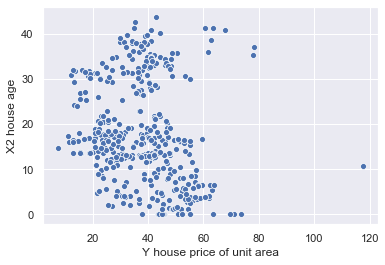

In [83]:
seaborn.scatterplot(x=df['Y house price of unit area'], y= df['X2 house age'])

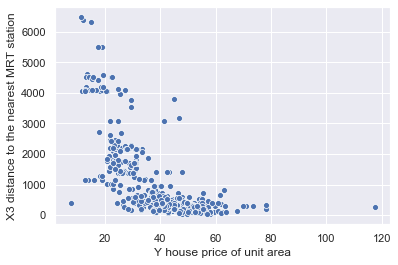

In [84]:
seaborn.scatterplot(x=df['Y house price of unit area'], y= df['X3 distance to the nearest MRT station'])

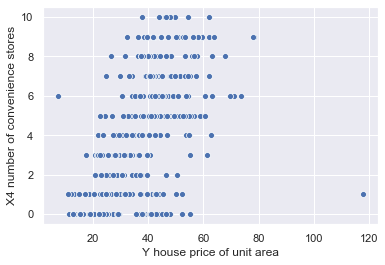

In [85]:
seaborn.scatterplot(x=df['Y house price of unit area'], y= df['X4 number of convenience stores'])

##### The scatterplots helps us answer the second question in terms of the trends existing between variables.  
##### It is evident by looking at the scatterplot between price and distance to the nearest MRT station, that the houses closer to the station are more expensive, which seems logical.  Also, it looks like the houses are expensive when they have more convenience stores close by.  There is no clear trend between house age and price.  

## Data Modeling

#### Function to parsing out the input data (in Excel) into 3 lists, which will then be used for data modeling:
1. house price for each record
2. raw data to train the model
3. feature names

In [86]:
def load_input(excel_file):

    """ To read an excel file and result into three lists .
     Args:
        excel_file: File to be read.
    """
    
    y_prediction = []
    data = []
    feature_names = []
 
    loc = (excel_file)
    wb = xlrd.open_workbook(loc)
    sheet = wb.sheet_by_index(0)
    sheet.cell_value(0, 0)

    #  reads all the rows from the data
    for index_row in range(0, 415):
        row = sheet.row_values(index_row)
        row = row[1:]
 
        if index_row == 0:
            feature_names = row
        else:
            row[0] = str(row[0]).split(".")[0]
            data.append([float(x) for x in row[:-1]])
            y_prediction.append(float(row[-1]))
 
    return y_prediction, data, feature_names[:-1]

#### Splitting the data into train (80%) and test (20%)

In [87]:
def split_data_train_model(labels, data):

    """ To split the data into test and train samples.
     Args:
        labels: list containing the dependent variable.
        data: list containing independent variables. 
    """

    # 20% examples in test data
    train, test, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, random_state = RF_SEED)
 
    # training data fit
    regressor = RandomForestRegressor(n_estimators = 1000, random_state = RF_SEED)
    regressor.fit(x_data, y_data)
 
    return test, test_labels, regressor

#### Running the predictions using Random Forest regression

In [88]:
y_data, x_data, feature_names = load_input("Real_estate_valuation_data_set.xlsx")
x_test, x_test_labels, regressor = split_data_train_model(y_data, x_data)
 
predictions = regressor.predict(x_test)

#### Function to create a scatter plot and save it as a .PNG file

In [89]:
def simple_scatter_plot(x_data, y_data, output_filename, title_name, x_axis_label, y_axis_label):
    """Simple scatter plot.
 
    Args:
        x_data (list): List with x-axis data.
        y_data (list): List with y-axis data.
        output_filename (str): Path to output image in PNG format.
        title_name (int): Plot title.
        x_axis_label (str): X-axis Label.
        y_axis_label (str): Y-axis Label.
 
    """
    seaborn.set(color_codes=True)
    matplotlib.figure(1, figsize=(9, 6)) 
    matplotlib.title(title_name) 
    ax = seaborn.scatterplot(x=x_data, y=y_data) 
    ax.set(xlabel=x_axis_label, ylabel=y_axis_label) 
    matplotlib.savefig(output_filename, bbox_inches='tight', dpi=300)
    matplotlib.close()

#### Correlation and Scatterplot between actual and predicted values

In [90]:
correlation = round(pearsonr(predictions, x_test_labels)[0], 5)
 
output_filename = "rf_regression.png"
title_name = "Random Forest Regression - Real House Price vs Predicted House Price - correlation ({})".format(correlation)
x_axis_label = "Real House Price"
y_axis_label = "Predicted House Price"
 
# plot data
simple_scatter_plot(x_test_labels, predictions, output_filename, title_name, x_axis_label, y_axis_label)

#### Feature importance of the predictors

In [91]:
features_importance = np.round(regressor.feature_importances_, 2)
 
print("Feature ranking:")
for i, data_class in enumerate(feature_names):
    print("{}. {} ({})".format(i + 1, data_class, features_importance[i]))

Feature ranking:
1. X1 transaction date (0.01)
2. X2 house age (0.19)
3. X3 distance to the nearest MRT station (0.6)
4. X4 number of convenience stores (0.02)
5. X5 latitude (0.1)
6. X6 longitude (0.08)


##### The feature importance helps us answer the third question in terms of the importance of variables on house price.  
##### With the help of Random Forest Regression algorithm, we can conclude that distance to the nearest MRT station is the most important variable for house price, followed by the house age.  